<a href="https://colab.research.google.com/github/desireechen/Deep-Learning/blob/master/Time_series%2C_sequences_and_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Get sunspot data.
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

In [ ]:
# Get temperature data.
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

In [ ]:
# OPTION 1 for plot series function.
def plot_series(time, series, format="-", start=0, end=None, label=None): # Sometimes do not have label argument.
    plt.plot(time[start:end], series[start:end], format, label=label) # Sometimes do not have label.
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True) # Can use either True or False.

In [ ]:
# OPTION 2 for plot series function.
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True) # Can use either True or False.

In [ ]:
# Process sunspot data.
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0])) #1st column contains the index number.
    sunspots.append(float(row[2])) #3rd column contains the sunspot.
# Make numpy array.
time = np.array(time_step)
series = np.array(sunspots)
# Plot.
plt.figure(figsize=(10, 6))
plot_series(time, series) # To see both train and test. Have not split yet.
plt.show()

In [ ]:
# Process temperature data.
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    time_step.append(step)
    temps.append(float(row[1]))
    step = step + 1
# Make numpy array.
time = np.array(time_step)
series = np.array(temps)
# Plot.
plt.figure(figsize=(10, 6))
plot_series(time, series) # To see both train and test. Have not split yet.
plt.show()

In [ ]:
def trend(time, slope=0):
    return slope * time

In [ ]:
# OPTION 1 for seasonal pattern function.
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [ ]:
# OPTION 2 for seasonal pattern function.
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

In [ ]:
# OPTION 3 for seasonal pattern function.
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

In [ ]:
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [ ]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
# For no Conv1D. This is to turn a series into a dataset which we can train on.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
# For Conv1D. This is to turn a series into a dataset which we can train on.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  series = tf.expand_dims(series, axis=-1) 
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(lambda w: (w[:-1], w[1:]))
  return dataset.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

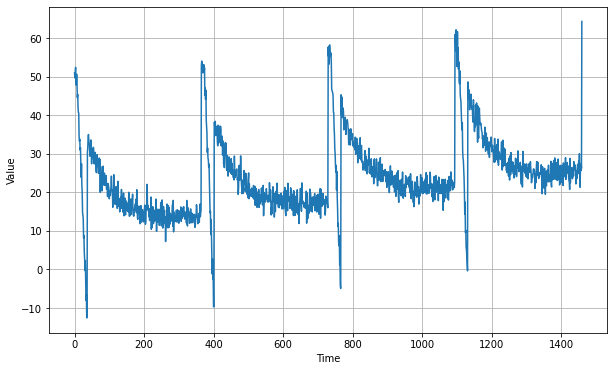

In [ ]:
time = np.arange(4 * 365 + 1, dtype="float32") # Instead of 4, it can be 10.
series = trend(time, 0.1)  
baseline = 10
amplitude = 40 # This can be 20 or 40.
slope = 0.01 # This can be 0.01, 0.05, 0.09 or 0.005.
noise_level = 2 # This can be 2, 3 or 5.
# Create the series.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise.
series += noise(time, noise_level, seed=42) # Can try other seed such as 51.
# Plot.
plt.figure(figsize=(10, 6))
plot_series(time, series) # To see both train and test. Have not split yet.
plt.show()

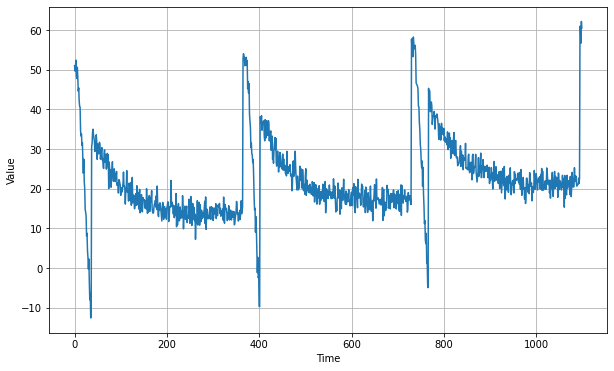

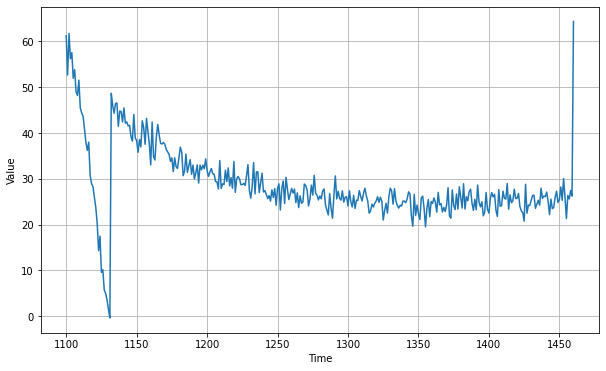

In [ ]:
split_time = 1100 # This number can be 1000, 1100, 2500 or 3000.
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [ ]:
# Always clear session before training another model.
tf.keras.backend.clear_session() # Clears any internal variables.
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
# Windowed dataset.
window_size = 20 # This can be 20, 30, 60 or 64.
batch_size = 32 # This can be 32, 100, 128 or 256.
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(dataset)
# print(x_train.shape)

In [ ]:
# Single layer.
single_layer = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([single_layer])
# model.summary()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse')

print('Layer weights {}'.format(single_layer.get_weights())) # 1st array has 20 weights for the 20 x values.
                                                            # 2nd array is the Bias.

print(series[1:21])
model.predict(series[1:21][np.newaxis])

In [ ]:
# DNN with Learning Rate Scheduler.
model = tf.keras.models.Sequential([tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'), 
                                    # Number above can be 10, 20 or 100.
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)])
# model.summary()
# Learning Rate Scheduler will adjust the learning rate over each epoch.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) # LR same as below and vice versa. Can be lr=1e-6, 1e-8, 8e-6, 5e-5, 1e-5 or 1e-7.
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss='mse', metrics=['mae']) 
num_epochs = 100 # This number can be 10, 30, 50, 100, 150, 400 or 500.
history = model.fit(dataset, epochs=num_epochs, callbacks=[lr_schedule], verbose=0)
# verbose 0, 1, 2 shows the least, most, in between information.

In [ ]:
# DNN without Learning Rate Scheduler.
model = tf.keras.models.Sequential([tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'), 
                                    # Number above can be 10, 20 or 100.
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)])
# model.summary()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['mae']) # Can be lr=1e-6, 1e-8, 8e-6, 5e-5, 1e-5 or 1e-7.
num_epochs = 100 # This number can be 10, 30, 50, 100, 150, 400 or 500.
model.fit(dataset, epochs=num_epochs,verbose=0)
# verbose 0, 1, 2 shows the least, most, in between information.

In [ ]:
# RNN with Learning Rate Scheduler.
model = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                                    tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(40),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*100.0)]) # This number can be 100.0 or 200 or 400, depends on range of numbers.
# Learning Rate Scheduler will adjust the learning rate over each epoch.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) # LR same as below and vice versa. Can be lr=1e-6, 1e-8, 8e-6, 5e-5, 1e-5 or 1e-7.
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae']) 
num_epochs = 100 # This number can be 10, 30, 50, 100, 150, 400 or 500.
history = model.fit(dataset, epochs=num_epochs,callbacks=[lr_schedule]) # Did not include verbose argument, so default.
# verbose 0, 1, 2 shows the least, most, in between information.

In [ ]:
# RNN without Learning Rate Scheduler.
model = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                                    tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(40),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*100.0)]) # This number can be 100.0 or 200 or 400, depends on range of numbers.
model.compile(optimizer=tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])
                                                  # Can be lr=1e-6, 1e-8, 8e-6, 5e-5, 1e-5 or 1e-7.
num_epochs = 100 # This number can be 10, 30, 50, 100, 150, 400 or 500.
history = model.fit(dataset, epochs=num_epochs) # Did not include verbose argument.
# verbose 0, 1, 2 shows the least, most, in between information.

In [ ]:
# LSTM with Learning Rate Scheduler.
model = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                    # LSTM number can be 32, 60 or 64.
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*100.0)]) # This number can be 100.0 or 200 or 400, depends on range of numbers.
# Learning Rate Scheduler will adjust the learning rate over each epoch.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) # LR same as below and vice versa. Can be lr=1e-6, 1e-8, 8e-6, 5e-5, 1e-5 or 1e-7.
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae']) 
num_epochs = 100 # This number can be 10, 30, 50, 100, 150, 400 or 500.
history = model.fit(dataset, epochs=num_epochs, callbacks=[lr_schedule]) # Did not include verbose argument.
# verbose 0, 1, 2 shows the least, most, in between information.

In [ ]:
# LSTM without Learning Rate Scheduler. Can have multi-layer LSTMs.
model = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                    # LSTM number can be 32, 60 or 64.
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*100.0)]) # This number can be 100.0 or 200 or 400, depends on range of numbers.
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), loss='mse', metrics=['mae']) 
                                          # Sometimes do not have metrics argument. Then, it is not shown in output.
                                          # Can be lr=1e-6, 1e-8, 8e-6, 5e-5, 1e-5 or 1e-7.
num_epochs = 100 # This number can be 10, 30, 50, 100, 150, 400 or 500.
history = model.fit(dataset, epochs=num_epochs) # Did not include verbose argument.
# verbose 0, 1, 2 shows the least, most, in between information.

In [ ]:
# Conv1D and LSTM with Learning Rate Scheduler.
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                                           padding='causal', activation='relu', input_shape=[None, 1]),
                                    # filters can be 32 or 60. kernel size 3 or 5. 
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), 
                                    # LSTM number can be 32, 60 or 64.
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    # tf.keras.layers.Dense(30, activation='relu'),
                                    # tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*100.0)]) # This number can be 100.0 or 200 or 400, depends on range of numbers.
# Learning Rate Scheduler will adjust the learning rate over each epoch.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) # LR same as below and vice versa. Can be lr=1e-6, 1e-8, 8e-6, 5e-5, 1e-5 or 1e-7.
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae']) 
num_epochs = 100 # This number can be 10, 30, 50, 100, 150, 400 or 500.
history = model.fit(dataset, epochs=num_epochs, callbacks=[lr_schedule]) # Did not include verbose argument.
# verbose 0, 1, 2 shows the least, most, in between information.

In [ ]:
# Conv1D and LSTM without Learning Rate Scheduler.
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, 
                                                           padding='causal', activation='relu', input_shape=[None, 1]),
                                    # filters can be 32 or 60. kernel size 3 or 5. 
                                    tf.keras.layers.LSTM(32, return_sequences=True), # LSTM number can be 32, 60 or 64.
                                    tf.keras.layers.LSTM(32, return_sequences=True), # LSTM number can be 32, 60 or 64.
                                    # tf.keras.layers.Dense(30, activation='relu'),
                                    # tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*100.0)]) # This number can be 100.0 or 200 or 400, depends on range of numbers.
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])
                                                # Can be lr=1e-6, 1e-8, 8e-6, 5e-5, 1e-5 or 1e-7.
num_epochs = 100 # This number can be 10, 30, 50, 100, 150, 400 or 500.
history = model.fit(dataset, epochs=num_epochs) # Did not include verbose argument.
# verbose 0, 1, 2 shows the least, most, in between information.

In [ ]:
# Extra code. Plot loss against learning rates. From plot, choose learning rate with minimum loss.
## EITHER THIS.
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
## OR THIS.
lrs = history.history['lr']
losses = history.history['loss']
plt.semilogx(lrs, losses)
plt.axis([1e-8, 1e-3, 0, 300]) # Can be [1e-8, 1e-4, 0, 30] or [1e-8, 1e-4, 0, 60]
                              # 1st 2 is the range of x-axis, next 2 is the range of the y-axis.

In [ ]:
# Extra code. Plot loss against epoch.
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

# Remove the 1st 10 epochs.
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [ ]:
# Forecasting. EITHER THIS.
forecast = []
results = [] 

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:] # Get the forecast after the split.
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# Print metrics MAE and MSE.
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()) # If did not use from tensorflow import keras
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy()) # If did not use from tensorflow import keras

In [ ]:
# Forecasting. OR THIS.
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
# print(rnn_forecast)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# Print metrics MAE and MSE.
print(keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()) # If did not use from tensorflow import keras
print(keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy())
print(tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy()) # If did not use from tensorflow import keras

In [ ]:
import matplotlib.pyplot as plt # If this is already imported before, then do not need to import again. 
# import matplotlib.image as mpimg

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get the number of epochs.

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])
plt.figure()

# Zoomed-in plot.
epochs_zoom = epochs[200:] # OR epochs_zoom = range(200,500)
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])
plt.figure()
# If see small spikes in the graphs, it may mean that the batch size is too small. Try using a larger batch size. 

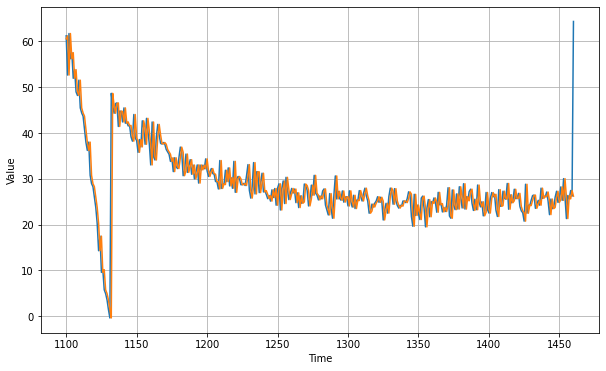

In [ ]:
naive_forecast = series[split_time - 1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

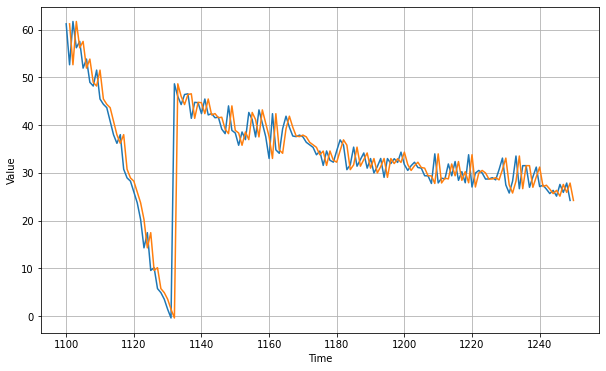

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [ ]:
# Compute MSE and MAE between forecasts and predictions in the validation period. This will be the baseline. 
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

19.578304
2.6011968


In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

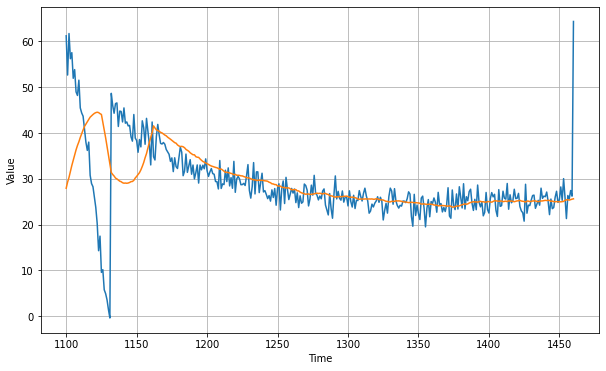

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
# Compute MSE and MAE between Moving Average forecasts and predictions in the validation period. This Moving Average is window size 30. 
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

65.786224
4.3040023


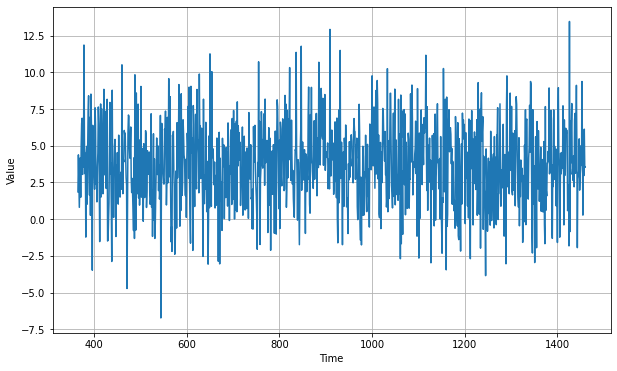

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

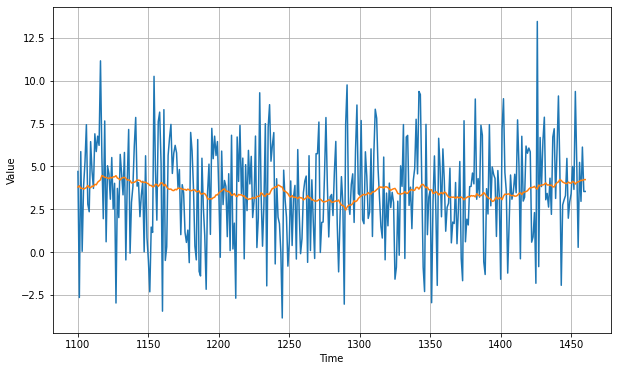

In [ ]:
# Use Moving Average function again after taking the difference in difference which is stationary.
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

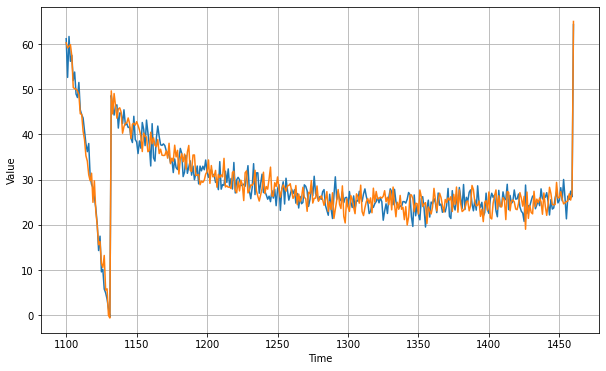

In [ ]:
# Bring back trend and seasonality by adding the past values from 365 days ago.
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
# Compute MSE and MAE between (Moving Average plus past values) forecasts and predictions in the validation period. 
# This Moving Average is window size 30. 
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

8.498155
2.327179


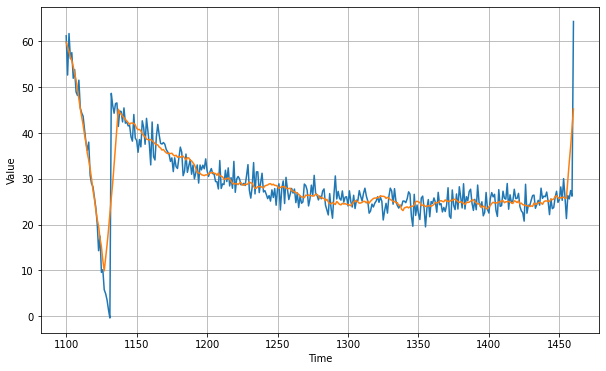

In [ ]:
# Also use Moving Average of 10 windows on past values.
diff_moving_avg_plus_smooth_past =  moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
# Compute MSE and MAE between (Moving Average on past values plus past values) forecasts and predictions in the validation period. 
# This Moving Average on past values is window size 10. 
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

12.527958
2.2034433


In [ ]:
# 1st definition of autocorrelation.
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [ ]:
# 2nd definition of autocorrelation.
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

In [ ]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

In [ ]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

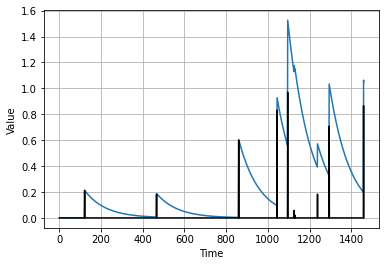

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

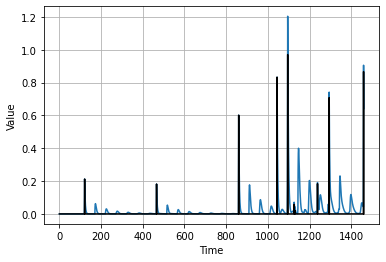

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2}) # The decay autocorrelates.
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

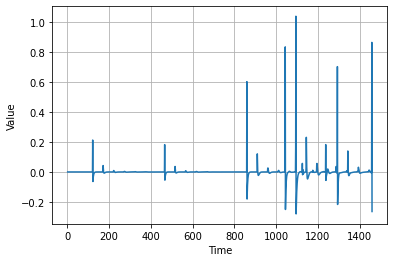

In [ ]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

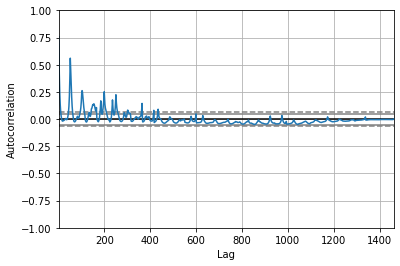

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Thu, 25 Jun 2020   AIC                          -4432.855
Time:                        12:23:40   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

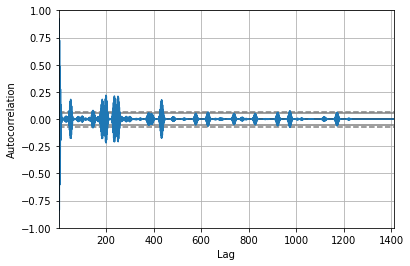

In [ ]:
series_diff = series
for lag in range(50):
  series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

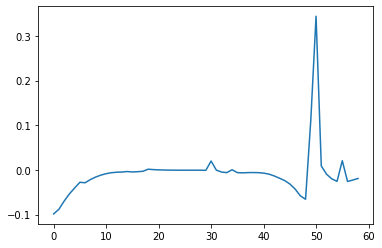

In [ ]:
import pandas as pd
series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()

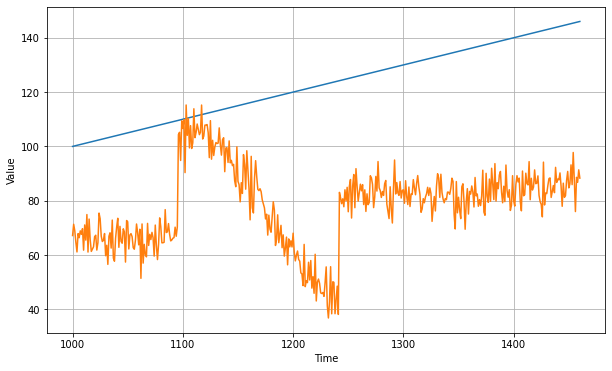

In [ ]:
naive_forecast = series[split_time - 1:-1] # naive prediction is to assume value at t+1 is the same as t which is the current value

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

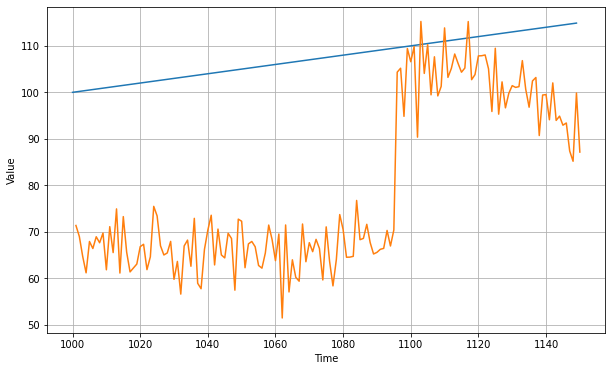

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)